# Enhanced Knowledge Graph Embeddings with PyKEEN

## Features:
- M3 Mac GPU acceleration (MPS backend)
- Multiple embedding models comparison
- Advanced visualizations (PCA, t-SNE, UMAP)
- Entity similarity and clustering analysis
- Link prediction and evaluation
- Relationship pattern analysis
- Interactive visualizations

## Installation

In [ ]:
!pip install -q pykeen torch pandas numpy matplotlib seaborn scikit-learn umap-learn plotly ipywidgets
# Enable widgets for Jupyter
!jupyter nbextension enable --py widgetsnbextension --sys-prefix 2>/dev/null || true

## Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyKEEN imports
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator
from pykeen import predict

# Visualization imports
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cosine, euclidean
from scipy.cluster.hierarchy import dendrogram, linkage

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available, install with: pip install umap-learn")

try:
    import plotly.graph_objects as go
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Plotly not available for interactive visualizations")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports complete")

✅ Imports complete


In [2]:
# M3 Mac GPU Acceleration Setup
def get_device():
    """Detect and configure optimal device for M3 Mac"""
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("🚀 Using M3 GPU (MPS backend)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("🚀 Using NVIDIA GPU")
    else:
        device = torch.device("cpu")
        print("⚠️  Using CPU (consider enabling MPS for M3 acceleration)")
    
    print(f"Device: {device}")
    print(f"PyTorch version: {torch.__version__}")
    return device

device = get_device()

# Configure for M3 optimization
torch.set_num_threads(8)  # Adjust based on M3 cores
print(f"CPU threads: {torch.get_num_threads()}")

🚀 Using M3 GPU (MPS backend)
Device: mps
PyTorch version: 2.8.0
CPU threads: 8


## Data Loading and Preparation

In [5]:
# Load edges table
df = pd.read_csv("original_kg/original-kg.csv")
df = df.drop(columns='attributes', errors='ignore')
df = df.rename(columns={'source': 'subject', 'target': 'object', 'relation': 'predicate'})

print(f"Loaded {len(df)} triples")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample triples:")
display(df.head())

# Statistics
print(f"\n📊 Dataset Statistics:")
print(f"  Unique entities: {len(set(df['subject'].unique().tolist() + df['object'].unique().tolist()))}")
print(f"  Unique relations: {len(df['predicate'].unique())}")
print(f"  Total triples: {len(df)}")
print(f"\nRelation distribution:")
print(df['predicate'].value_counts())

Loaded 1204 triples

Columns: ['subject', 'predicate', 'object']

Sample triples:


,subject,predicate,object
0,Abraham Trust,partnered,Geoffrey Jenkinson
1,Benjamin Bishop Johnson,appraised_art_for,David Swetnam
2,Donald Hales,appraised_art_for,Leonardo Patterson
3,Giacomo Medici,appraised_art_for,Nikolas Koutoulakis
4,Jack Ogden,appraised_art_for,Michael Ward Gallery



📊 Dataset Statistics:
  Unique entities: 477
  Unique relations: 81
  Total triples: 1204

Relation distribution:
predicate
partnered              118
bought_from            117
sold_antiquities_to    109
base_for                50
employed                49
                      ... 
transfered_to            1
wanted_by                1
director_of              1
offered_for_sale         1
sued                     1
Name: count, Length: 81, dtype: int64


In [6]:
# Create triples factory
triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['subject', 'predicate', 'object']].values,
)

# Create train/validation/test split
# For small graphs, we use the same data (in production, use proper split)
training, validation, testing = triples_factory.split([0.7, 0.15, 0.15], random_state=42)

print(f"\n📦 Data Split:")
print(f"  Training: {training.num_triples} triples")
print(f"  Validation: {validation.num_triples} triples")
print(f"  Testing: {testing.num_triples} triples")

# Create lookup dictionaries
id_to_entity = {v: k for k, v in triples_factory.entity_to_id.items()}
id_to_relation = {v: k for k, v in triples_factory.relation_to_id.items()}

print("\n✅ Triples factory created")


📦 Data Split:
  Training: 842 triples
  Validation: 181 triples
  Testing: 181 triples

✅ Triples factory created


## Model Training and Comparison

We'll train multiple models to compare performance:
- **TransE**: Translational model (entities + relations in same space)
- **RotatE**: Rotation-based embeddings in complex space
- **ComplEx**: Complex embeddings with Hermitian dot product
- **DistMult**: Bilinear diagonal model
- **ConvE**: Convolutional model

In [7]:
# Configuration for M3 optimization
EMBEDDING_DIM = 64  # Increased for better representation
NUM_EPOCHS = 300
BATCH_SIZE = 256  # Optimized for M3 GPU
LEARNING_RATE = 0.001

# Model configurations
models_config = {
    'TransE': {
        'model': 'TransE',
        'loss': 'softplus',
        'model_kwargs': {'embedding_dim': EMBEDDING_DIM},
        'optimizer_kwargs': {'lr': LEARNING_RATE},
    },
    'RotatE': {
        'model': 'RotatE',
        'model_kwargs': {'embedding_dim': EMBEDDING_DIM},
        'optimizer_kwargs': {'lr': LEARNING_RATE},
    },
    'ComplEx': {
        'model': 'ComplEx',
        'model_kwargs': {'embedding_dim': EMBEDDING_DIM},
        'optimizer_kwargs': {'lr': LEARNING_RATE},
    },
    'DistMult': {
        'model': 'DistMult',
        'model_kwargs': {'embedding_dim': EMBEDDING_DIM},
        'optimizer_kwargs': {'lr': LEARNING_RATE},
    },
}

print(f"\n🎯 Training Configuration:")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Device: {device}")


🎯 Training Configuration:
  Embedding dimension: 64
  Batch size: 256
  Epochs: 300
  Learning rate: 0.001
  Device: mps


In [8]:
def train_model(model_name, config):
    """Train a model with M3 optimization"""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    # Models with complex embeddings don't work on MPS yet
    complex_models = {'RotatE', 'ComplEx'}
    use_device = 'cpu' if (str(device) == 'mps' and model_name in complex_models) else str(device)
    
    if use_device == 'cpu' and str(device) == 'mps':
        print(f"⚠️  {model_name} uses complex embeddings - falling back to CPU (MPS limitation)")
    
    result = pipeline(
        training=training,
        validation=validation,
        testing=testing,
        **config,
        training_kwargs={
            'num_epochs': NUM_EPOCHS,
            'batch_size': BATCH_SIZE,
            'use_tqdm_batch': False,  # Original config that worked
        },
        device=use_device,
        random_seed=42,
    )
    
    print(f"✅ {model_name} training complete")
    return result

# Train all models
results = {}
for model_name, config in models_config.items():
    try:
        results[model_name] = train_model(model_name, config)
    except Exception as e:
        print(f"❌ Error training {model_name}: {e}")
        print(f"   Skipping this model...")
        continue

print("\n" + "="*60)
print(f"Successfully trained {len(results)} models!")
print("="*60)


Training TransE


Training epochs on mps:0:   0%|          | 0/300 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/181 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


✅ TransE training complete

Training RotatE
⚠️  RotatE uses complex embeddings - falling back to CPU (MPS limitation)


Training epochs on cpu:   0%|          | 0/300 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/181 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)


✅ RotatE training complete

Training ComplEx
⚠️  ComplEx uses complex embeddings - falling back to CPU (MPS limitation)


Training epochs on cpu:   0%|          | 0/300 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/181 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.pipeline.api:Using device: mps
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)


✅ ComplEx training complete

Training DistMult


Training epochs on mps:0:   0%|          | 0/300 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/181 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds


✅ DistMult training complete

Successfully trained 4 models!


## Model Evaluation and Comparison

In [9]:
# Evaluate all models
evaluator = RankBasedEvaluator()
metrics_comparison = {}

for model_name, result in results.items():
    print(f"\nEvaluating {model_name}...")
    
    metrics = evaluator.evaluate(
        result.model,
        testing.mapped_triples,
        additional_filter_triples=[training.mapped_triples, validation.mapped_triples]
    )
    
    metrics_comparison[model_name] = {
        'Hits@1': metrics.get_metric('hits@1'),
        'Hits@3': metrics.get_metric('hits@3'),
        'Hits@5': metrics.get_metric('hits@5'),
        'Hits@10': metrics.get_metric('hits@10'),
        'MRR': metrics.get_metric('mean_reciprocal_rank'),
    }
    
    print(f"  Hits@1: {metrics_comparison[model_name]['Hits@1']:.4f}")
    print(f"  Hits@10: {metrics_comparison[model_name]['Hits@10']:.4f}")
    print(f"  MRR: {metrics_comparison[model_name]['MRR']:.4f}")

# Convert to DataFrame for comparison
metrics_df = pd.DataFrame(metrics_comparison).T
print("\n📊 Model Performance Comparison:")
display(metrics_df.style.highlight_max(axis=0, color='lightgreen'))


Evaluating TransE...


Evaluating on mps:0:   0%|          | 0.00/181 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.11s seconds


  Hits@1: 0.3398
  Hits@10: 0.6961
  MRR: 0.4670

Evaluating RotatE...


Evaluating on cpu:   0%|          | 0.00/181 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


  Hits@1: 0.1050
  Hits@10: 0.3702
  MRR: 0.1932

Evaluating ComplEx...


Evaluating on cpu:   0%|          | 0.00/181 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


  Hits@1: 0.0000
  Hits@10: 0.0221
  MRR: 0.0119

Evaluating DistMult...


Evaluating on mps:0:   0%|          | 0.00/181 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


  Hits@1: 0.5387
  Hits@10: 0.6547
  MRR: 0.5831

📊 Model Performance Comparison:


,Hits@1,Hits@3,Hits@5,Hits@10,MRR
TransE,0.339779,0.552486,0.613260,0.696133,0.466988
RotatE,0.104972,0.218232,0.267956,0.370166,0.193163
ComplEx,0.000000,0.002762,0.002762,0.022099,0.011875
DistMult,0.538674,0.599448,0.624309,0.654696,0.583134


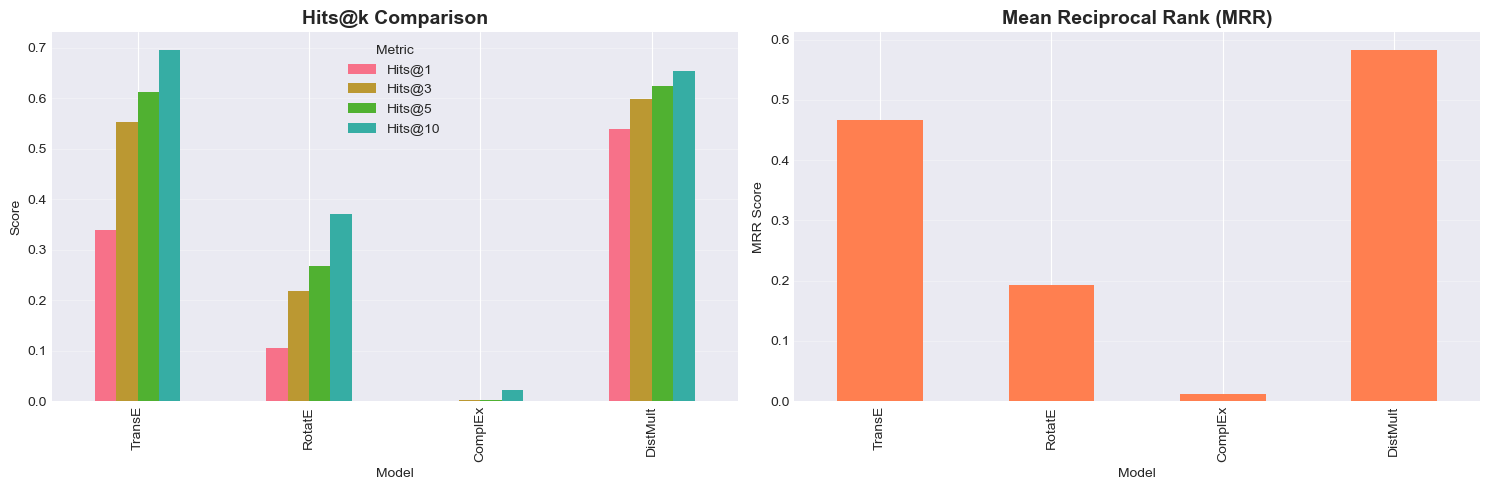


🏆 Best performing model: DistMult
   MRR: 0.5831


In [10]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Hits@k comparison
hits_metrics = metrics_df[['Hits@1', 'Hits@3', 'Hits@5', 'Hits@10']]
hits_metrics.plot(kind='bar', ax=axes[0])
axes[0].set_title('Hits@k Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(title='Metric')
axes[0].grid(axis='y', alpha=0.3)

# MRR comparison
metrics_df['MRR'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Mean Reciprocal Rank (MRR)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MRR Score')
axes[1].set_xlabel('Model')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best model
best_model_name = metrics_df['MRR'].idxmax()
print(f"\n🏆 Best performing model: {best_model_name}")
print(f"   MRR: {metrics_df.loc[best_model_name, 'MRR']:.4f}")

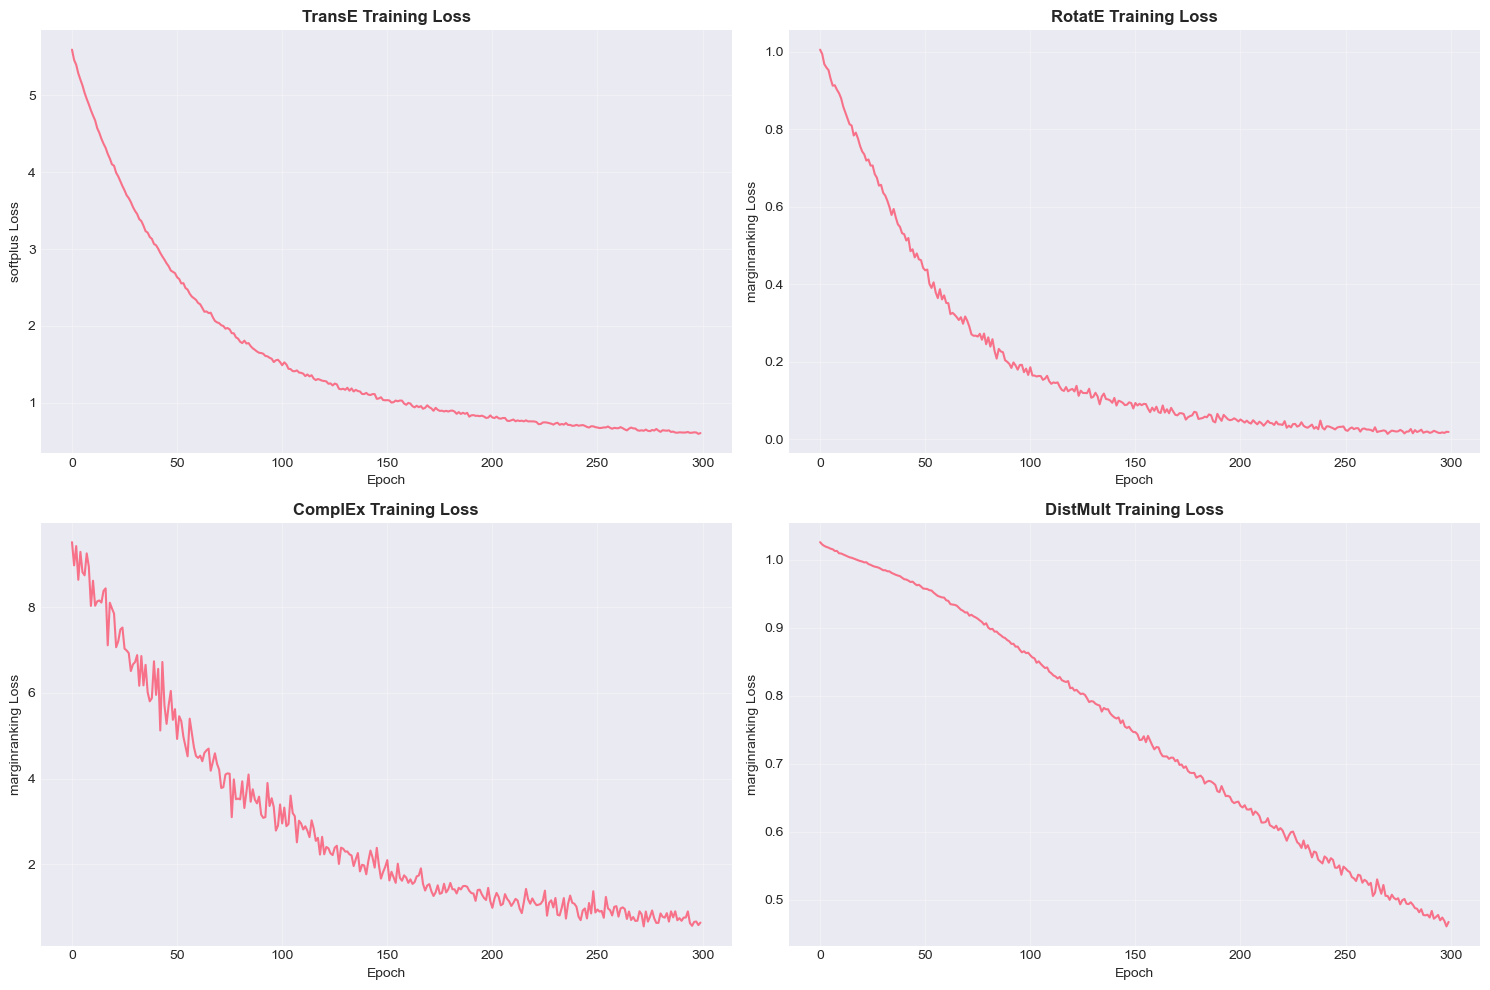

In [11]:
# Plot training losses for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (model_name, result) in enumerate(results.items()):
    if idx < len(axes):
        result.plot_losses(ax=axes[idx])
        axes[idx].set_title(f'{model_name} Training Loss', fontweight='bold')
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_losses.png', dpi=300, bbox_inches='tight')
plt.show()

## Embedding Analysis

Now we'll explore the learned embeddings using the best model.

In [12]:
import torch
# Use best model for detailed analysis
best_model = results[best_model_name].model

# Extract embeddings - handle complex-valued models
entity_embeddings_raw = best_model.entity_representations[0](indices=None).detach().cpu()
relation_embeddings_raw = best_model.relation_representations[0](indices=None).detach().cpu()

# Convert complex to real if necessary
if entity_embeddings_raw.is_complex():
    print(f"Converting complex embeddings to real (using magnitude)...")
    # Use magnitude for complex embeddings (could also use real part or concatenate real+imag)
    entity_embeddings = torch.abs(entity_embeddings_raw).numpy()
    relation_embeddings = torch.abs(relation_embeddings_raw).numpy()
else:
    entity_embeddings = entity_embeddings_raw.numpy()
    relation_embeddings = relation_embeddings_raw.numpy()

print(f"\n📐 Embedding Dimensions:")
print(f"  Entity embeddings: {entity_embeddings.shape}")
print(f"  Relation embeddings: {relation_embeddings.shape}")
print(f"  Using {best_model_name} model for analysis")
print(f"  Embeddings are: {'real-valued' if not entity_embeddings_raw.is_complex() else 'complex (converted to magnitude)'}")


📐 Embedding Dimensions:
  Entity embeddings: (477, 64)
  Relation embeddings: (81, 64)
  Using DistMult model for analysis
  Embeddings are: real-valued


### 2D Visualizations: PCA, t-SNE, UMAP

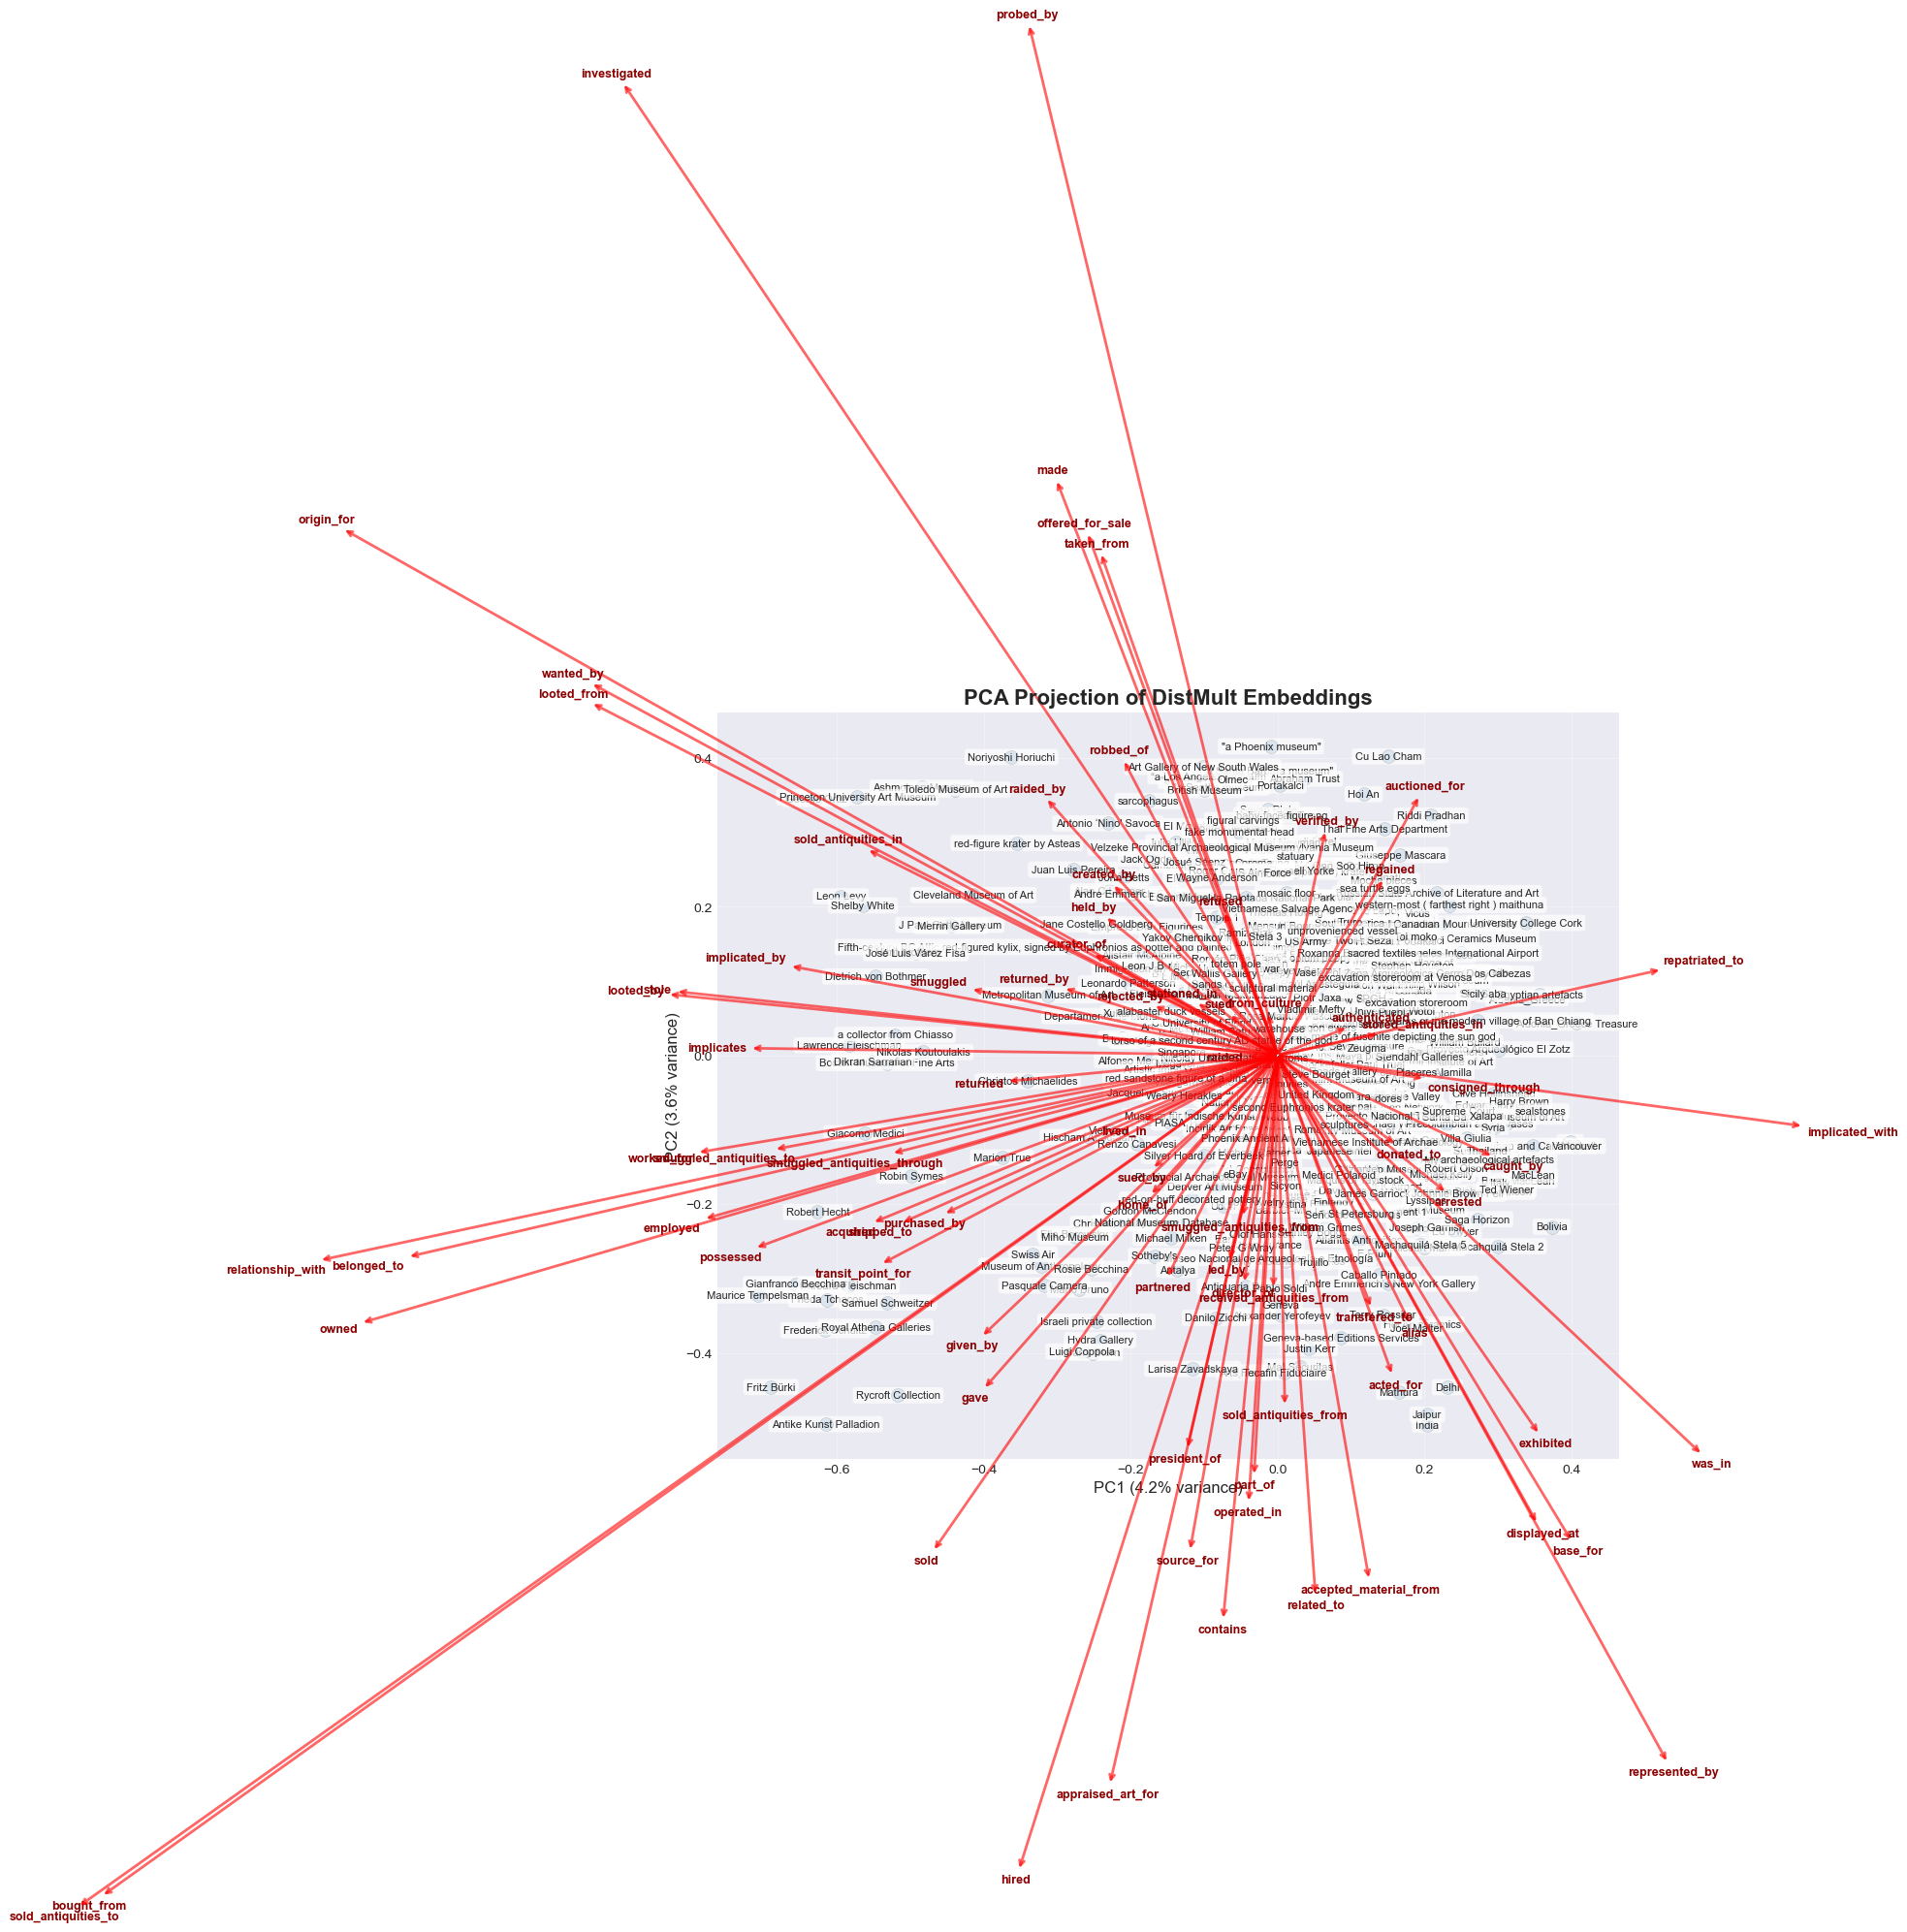


PCA explained variance: 7.9%


In [13]:
# PCA Visualization
pca = PCA(n_components=2, random_state=42)
entity_pca = pca.fit_transform(entity_embeddings)
relation_pca = pca.transform(relation_embeddings)

plt.figure(figsize=(12, 10))

# Plot entities
plt.scatter(entity_pca[:, 0], entity_pca[:, 1], c='steelblue', 
           s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

for i, entity_id in enumerate(triples_factory.entity_id_to_label):
    plt.annotate(
        text=id_to_entity[entity_id],
        xy=(entity_pca[i, 0], entity_pca[i, 1]),
        fontsize=8,
        ha='center',
        va='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )

# Plot relations as arrows from origin
for i, relation_id in enumerate(triples_factory.relation_id_to_label):
    plt.annotate(
        text=id_to_relation[relation_id],
        xy=(0, 0),
        xytext=(relation_pca[i, 0], relation_pca[i, 1]),
        arrowprops=dict(
            arrowstyle='<-',
            color='red',
            lw=2,
            alpha=0.6
        ),
        fontsize=9,
        fontweight='bold',
        color='darkred'
    )

plt.title(f'PCA Projection of {best_model_name} Embeddings', fontsize=16, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pca_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPCA explained variance: {pca.explained_variance_ratio_.sum():.1%}")

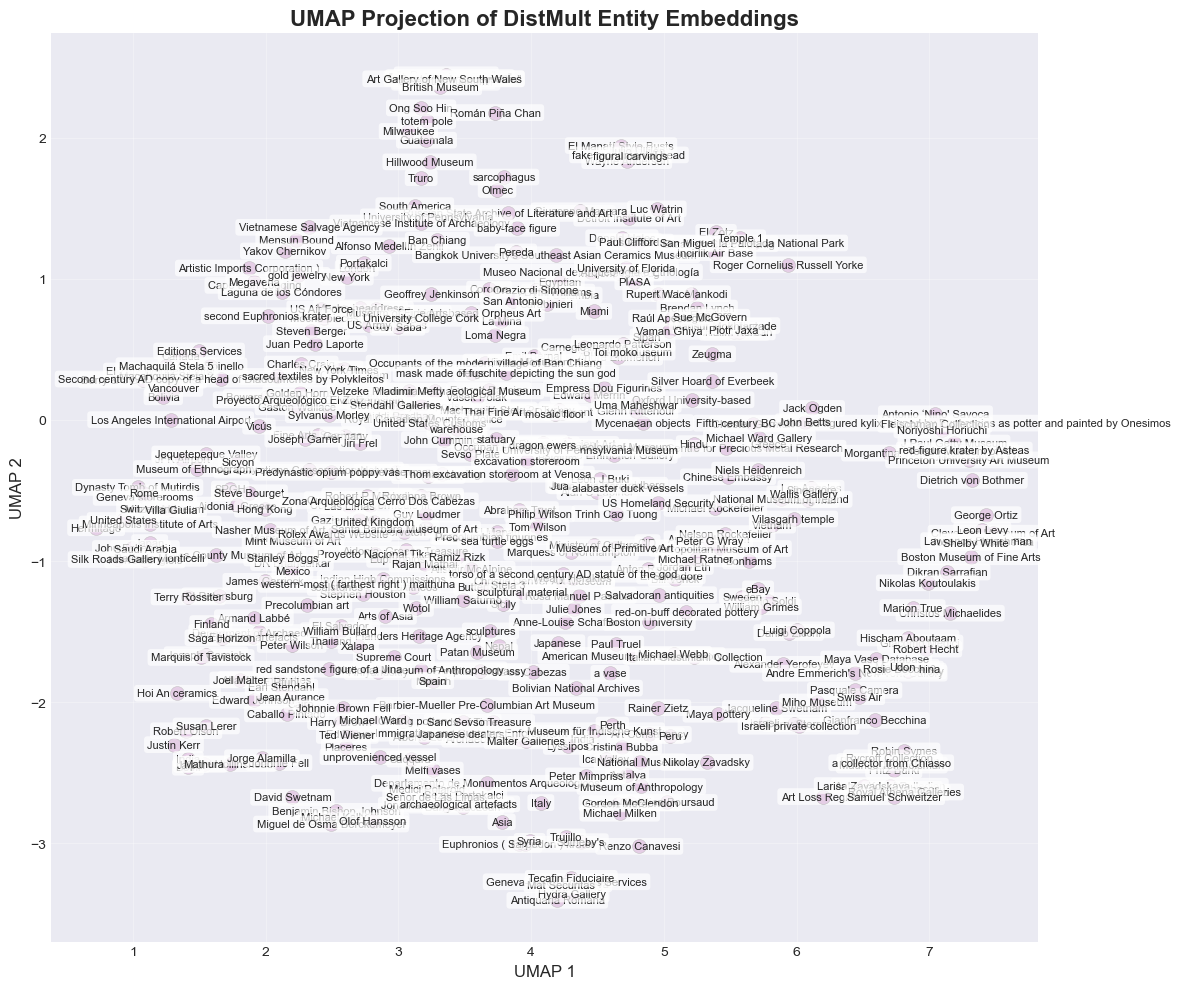

In [14]:
# UMAP Visualization (if available)
if UMAP_AVAILABLE and len(entity_embeddings) >= 15:
    reducer = umap.UMAP(n_components=2, random_state=42)
    entity_umap = reducer.fit_transform(entity_embeddings)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(entity_umap[:, 0], entity_umap[:, 1], c='purple', 
               s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    for i, entity_id in enumerate(triples_factory.entity_id_to_label):
        plt.annotate(
            text=id_to_entity[entity_id],
            xy=(entity_umap[i, 0], entity_umap[i, 1]),
            fontsize=8,
            ha='center',
            va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
        )
    
    plt.title(f'UMAP Projection of {best_model_name} Entity Embeddings', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP 1', fontsize=12)
    plt.ylabel('UMAP 2', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('umap_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️  UMAP visualization skipped (not available or insufficient data)")

### Entity Similarity Analysis

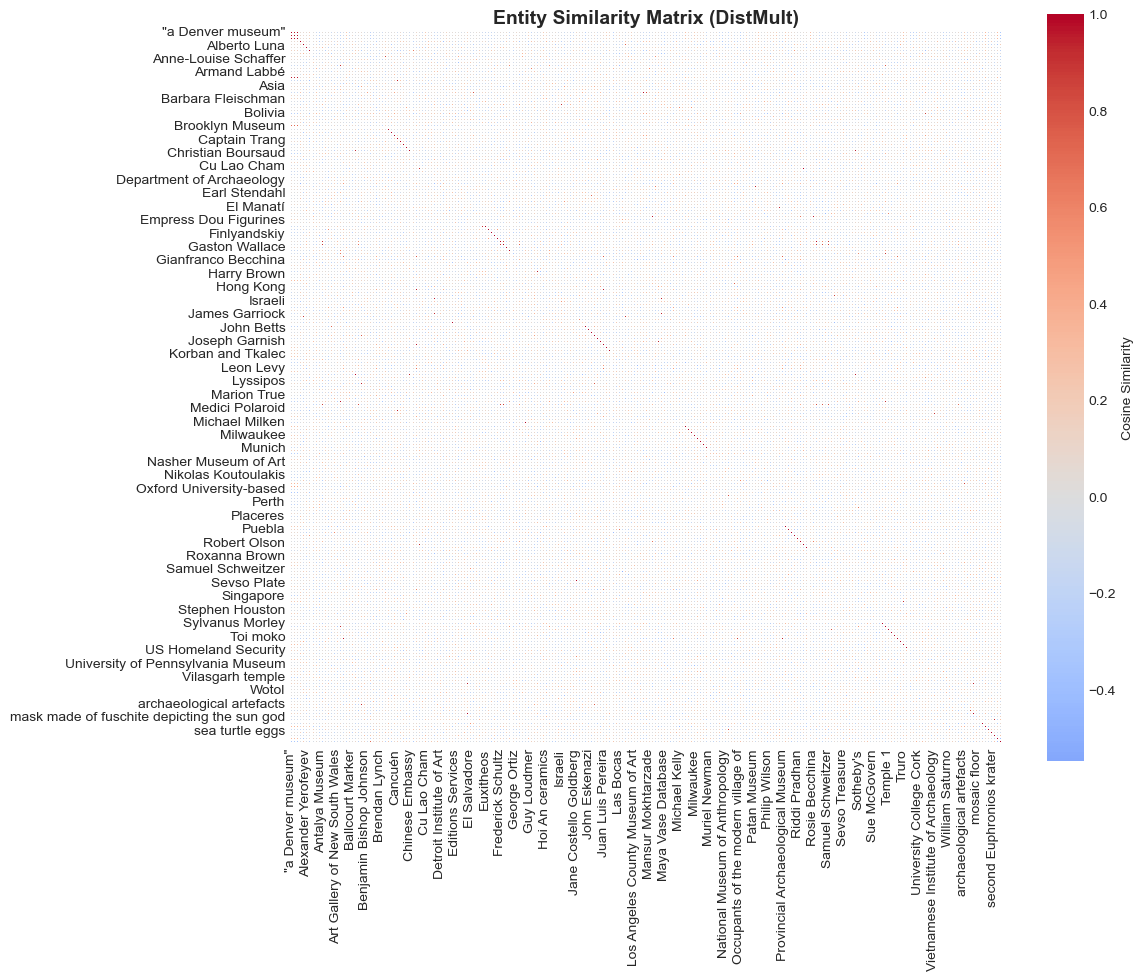


🔍 Most Similar Entity Pairs:
  1. "a Denver museum" <-> "a Los Angeles museum": 0.9934
  2. Artistic Imports Corporation ) <-> Megavena: 0.9927
  3. Curator of Provenance <-> Robert P Mitchell: 0.9908
  4. fake monumental head <-> figural carvings: 0.9906
  5. Bangkok <-> Los Angeles: 0.9903
  6. El Manatí Style Busts <-> fake monumental head: 0.9896
  7. "a Los Angeles museum" <-> "a Seattle museum": 0.9884
  8. "a Denver museum" <-> "a Seattle museum": 0.9883
  9. Japan <-> Saudi Arabia: 0.9882
  10. El Manatí Style Busts <-> figural carvings: 0.9880


In [15]:
# Compute pairwise cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(entity_embeddings)

# Create DataFrame with entity labels
entity_labels = [id_to_entity[i] for i in range(len(id_to_entity))]
similarity_df = pd.DataFrame(similarity_matrix, index=entity_labels, columns=entity_labels)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='coolwarm', center=0, 
            annot=len(entity_labels) < 15, fmt='.2f',
            square=True, linewidths=0.5, cbar_kws={'label': 'Cosine Similarity'})
plt.title(f'Entity Similarity Matrix ({best_model_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('similarity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Most Similar Entity Pairs:")
# Find top similar pairs (excluding diagonal)
np.fill_diagonal(similarity_matrix, -1)
top_pairs = []
for i in range(len(entity_labels)):
    for j in range(i+1, len(entity_labels)):
        top_pairs.append((entity_labels[i], entity_labels[j], similarity_matrix[i, j]))

top_pairs.sort(key=lambda x: x[2], reverse=True)
for i, (e1, e2, sim) in enumerate(top_pairs[:10]):
    print(f"  {i+1}. {e1} <-> {e2}: {sim:.4f}")

In [21]:
# Function to find most similar entities
def find_similar_entities(entity_name, top_k=5):
    """Find most similar entities to a given entity"""
    if entity_name not in triples_factory.entity_to_id:
        print(f"Entity '{entity_name}' not found")
        return
    
    entity_id = triples_factory.entity_to_id[entity_name]
    entity_embedding = entity_embeddings[entity_id]
    
    # Compute similarities
    similarities = cosine_similarity([entity_embedding], entity_embeddings)[0]
    
    # Get top-k (excluding self)
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    print(f"\n🎯 Top {top_k} entities most similar to '{entity_name}':")
    for i, idx in enumerate(top_indices):
        similar_entity = id_to_entity[idx]
        similarity = similarities[idx]
        print(f"  {i+1}. {similar_entity}: {similarity:.4f}")
    
    return [(id_to_entity[idx], similarities[idx]) for idx in top_indices]

# Example: Find entities similar to a specific one
# Replace with an actual entity from your graph
if len(entity_labels) > 0:
    example_entity = entity_labels[226]
    find_similar_entities(example_entity)


🎯 Top 5 entities most similar to 'Leonardo Patterson':
  1. Brooklyn Museum: 0.3828
  2. André Emmerich: 0.3563
  3. Marjorie Neikrug: 0.3553
  4. Loma Negra: 0.2723
  5. Swiss Air: 0.2666


### Clustering Analysis

In [ ]:
# K-Means clustering
optimal_k = min(5, len(entity_embeddings) // 2)

# Elbow method to find optimal k
if len(entity_embeddings) >= 10:
    inertias = []
    silhouette_scores = []
    k_range = range(2, min(10, len(entity_embeddings)))
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(entity_embeddings)
        inertias.append(kmeans.inertia_)
        if k < len(entity_embeddings):
            silhouette_scores.append(silhouette_score(entity_embeddings, labels))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Elbow plot
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[0].set_ylabel('Inertia', fontsize=12)
    axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Silhouette plot
    axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[1].set_ylabel('Silhouette Score', fontsize=12)
    axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('clustering_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Use k with best silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\n✅ Optimal number of clusters: {optimal_k}")

In [ ]:
# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(entity_embeddings)

# Visualize clusters in PCA space
plt.figure(figsize=(12, 10))
scatter = plt.scatter(entity_pca[:, 0], entity_pca[:, 1], 
                     c=cluster_labels, cmap='viridis', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

for i, entity_id in enumerate(triples_factory.entity_id_to_label):
    plt.annotate(
        text=id_to_entity[entity_id],
        xy=(entity_pca[i, 0], entity_pca[i, 1]),
        fontsize=8,
        ha='center',
        va='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )

plt.colorbar(scatter, label='Cluster')
plt.title(f'Entity Clusters (K-Means, k={optimal_k})', fontsize=16, fontweight='bold')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('entity_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Print cluster assignments
print("\n📊 Cluster Assignments:")
for cluster_id in range(optimal_k):
    cluster_entities = [entity_labels[i] for i in range(len(entity_labels)) 
                       if cluster_labels[i] == cluster_id]
    print(f"\n  Cluster {cluster_id}: {len(cluster_entities)} entities")
    print(f"    {', '.join(cluster_entities)}")

In [ ]:
# Hierarchical clustering dendrogram
if len(entity_embeddings) < 50:  # Only for smaller graphs
    plt.figure(figsize=(14, 8))
    linkage_matrix = linkage(entity_embeddings, method='ward')
    
    dendrogram(
        linkage_matrix,
        labels=entity_labels,
        leaf_font_size=10,
        leaf_rotation=90
    )
    
    plt.title('Hierarchical Clustering Dendrogram', fontsize=16, fontweight='bold')
    plt.xlabel('Entity', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.tight_layout()
    plt.savefig('dendrogram.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️  Dendrogram skipped (too many entities for clear visualization)")

## Link Prediction and Analysis

In [ ]:
# Example: Predict missing links
print("\n🔮 Link Prediction Examples:\n")

# Predict tail entity for given head and relation
if len(entity_labels) >= 2:
    example_head = entity_labels[0]
    example_relation = list(triples_factory.relation_to_id.keys())[0]
    
    print(f"Query: ({example_head}, {example_relation}, ?)")
    
    predictions = predict.predict_target(
        model=best_model,
        head=example_head,
        relation=example_relation,
        triples_factory=triples_factory
    ).add_membership_columns(training=training, testing=testing)
    
    print("\nTop 10 predictions:")
    display(predictions.df.head(10))

In [ ]:
# Score unseen triples
print("\n🎲 Scoring Hypothetical Triples:\n")

# Create some plausible unseen triples to score
# Adjust these based on your actual entities and relations
if len(entity_labels) >= 3:
    unseen_triples = np.array([
        [entity_labels[0], list(triples_factory.relation_to_id.keys())[0], entity_labels[1]],
        [entity_labels[1], list(triples_factory.relation_to_id.keys())[0], entity_labels[2]],
    ])
    
    unseen_factory = TriplesFactory.from_labeled_triples(triples=unseen_triples)
    
    predictions = predict.predict_triples(
        model=best_model,
        triples=unseen_factory
    )
    
    results_df = predictions.process(factory=unseen_factory).df
    print("Triple plausibility scores:")
    display(results_df)

### Relation Pattern Analysis

In [ ]:
# Analyze relation embeddings
relation_labels = [id_to_relation[i] for i in range(len(id_to_relation))]

# Compute relation similarity
relation_similarity = cosine_similarity(relation_embeddings)
relation_similarity_df = pd.DataFrame(
    relation_similarity,
    index=relation_labels,
    columns=relation_labels
)

if len(relation_labels) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(relation_similarity_df, annot=True, fmt='.2f', 
                cmap='RdYlGn', center=0, square=True,
                cbar_kws={'label': 'Cosine Similarity'})
    plt.title('Relation Similarity Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('relation_similarity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n🔗 Most Similar Relation Pairs:")
    np.fill_diagonal(relation_similarity, -1)
    for i in range(len(relation_labels)):
        for j in range(i+1, len(relation_labels)):
            sim = relation_similarity[i, j]
            if sim > 0.5:  # Only show reasonably similar pairs
                print(f"  {relation_labels[i]} <-> {relation_labels[j]}: {sim:.4f}")

## Interactive Visualizations (Plotly)

In [ ]:
if PLOTLY_AVAILABLE:
    # 3D PCA visualization
    pca_3d = PCA(n_components=3, random_state=42)
    entity_pca_3d = pca_3d.fit_transform(entity_embeddings)
    
    fig = go.Figure(data=[go.Scatter3d(
        x=entity_pca_3d[:, 0],
        y=entity_pca_3d[:, 1],
        z=entity_pca_3d[:, 2],
        mode='markers+text',
        marker=dict(
            size=10,
            color=cluster_labels if len(cluster_labels) == len(entity_labels) else None,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Cluster"),
            line=dict(color='black', width=0.5)
        ),
        text=entity_labels,
        textposition='top center',
        textfont=dict(size=10),
    )])
    
    fig.update_layout(
        title=f'Interactive 3D Entity Embeddings ({best_model_name})',
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        ),
        width=1000,
        height=800
    )
    
    fig.write_html('interactive_embeddings_3d.html')
    print("\n✅ Saved interactive 3D visualization to 'interactive_embeddings_3d.html'")
    fig.show()
else:
    print("⚠️  Plotly not available for interactive visualizations")

## Save Results and Embeddings

In [ ]:
# Save embeddings
output_dir = Path('embedding_output')
output_dir.mkdir(exist_ok=True)

# Save entity embeddings
entity_embedding_df = pd.DataFrame(
    entity_embeddings,
    index=entity_labels
)
entity_embedding_df.to_csv(output_dir / 'entity_embeddings.csv')

# Save relation embeddings
relation_embedding_df = pd.DataFrame(
    relation_embeddings,
    index=relation_labels
)
relation_embedding_df.to_csv(output_dir / 'relation_embeddings.csv')

# Save similarity matrix
similarity_df.to_csv(output_dir / 'entity_similarity.csv')

# Save cluster assignments
cluster_df = pd.DataFrame({
    'entity': entity_labels,
    'cluster': cluster_labels
})
cluster_df.to_csv(output_dir / 'entity_clusters.csv', index=False)

# Save metrics
metrics_df.to_csv(output_dir / 'model_metrics.csv')

# Save best model
results[best_model_name].save_to_directory(str(output_dir / 'best_model'))

print(f"\n✅ All results saved to '{output_dir}' directory")
print(f"\nSaved files:")
for file in output_dir.glob('*'):
    print(f"  - {file.name}")

## Summary and Insights

### Key Findings:

In [ ]:
print("\n" + "="*70)
print("KNOWLEDGE GRAPH EMBEDDING ANALYSIS SUMMARY")
print("="*70)

print(f"\n📊 Dataset Statistics:")
print(f"  Total triples: {len(df)}")
print(f"  Unique entities: {len(entity_labels)}")
print(f"  Unique relations: {len(relation_labels)}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"  MRR: {metrics_df.loc[best_model_name, 'MRR']:.4f}")
print(f"  Hits@1: {metrics_df.loc[best_model_name, 'Hits@1']:.4f}")
print(f"  Hits@10: {metrics_df.loc[best_model_name, 'Hits@10']:.4f}")

print(f"\n🎯 Hardware Utilization:")
print(f"  Device: {device}")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Batch size: {BATCH_SIZE}")

print(f"\n🔍 Embedding Insights:")
print(f"  Optimal clusters: {optimal_k}")
print(f"  PCA variance explained: {pca.explained_variance_ratio_.sum():.1%}")

print(f"\n📁 Output Location: {output_dir.absolute()}")

print("\n" + "="*70)